# Data report for the cytotox dataset for LNA gapmers

This dataset was sourced from https://doi.org/10.1016/j.omtn.2019.12.011. This study investigated the cytotoxic potential of LNA gapmers in HeLa cells. The readout was caspase activation after 24 hours of transfection with 100nM of ASO.

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.features import OneHotEncoder
from oligogym.helm import helm2xna
from oligogym.models import RandomForestModel
from oligogym.metrics import regression_metrics
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Processed dataset


In [2]:
downloader = DatasetDownloader()
dataset = downloader.download("cytotox_lna")
dataset.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{[lna](T)[sp].[lna](G)[sp].[lna](G)[sp].[l...,0.416884,348.966482,HIF1A,Cc1cn([C@@H]2O[C@@]3(COP(=O)(S)O[C@H]4C[C@H](n...,TGGCAAGCATCCTGTA
1,RNA1{[lna](T)[sp].[lna](G)[sp].[lna](G)[sp].[l...,0.567016,444.789440,HIF1A,Cc1cn([C@@H]2O[C@@]3(COP(=O)(S)O[C@H]4[C@H]5OC...,TGGCAAGCATCCTGTA
2,RNA1{[lna](T)[sp].[lna](G)[sp].[lna](G)[sp].[l...,0.519097,414.204731,HIF1A,Cc1cn([C@@H]2O[C@@]3(COP(=O)(S)O[C@H]4[C@H]5OC...,TGGCAAGCATCCTGTA
3,RNA1{[lna](T)[sp].[lna](G)[sp].[lna](G)[sp].d(...,0.710437,536.329417,HIF1A,Cc1cn([C@@H]2O[C@@]3(COP(=O)(S)O[C@H]4[C@H]5OC...,TGGCAAGCATCCTGTA
4,RNA1{[lna](T)[sp].[lna](G)[sp].[lna](G)[sp].d(...,0.615823,475.940782,HIF1A,Cc1cn([C@@H]2O[C@@]3(COP(=O)(S)O[C@H]4[C@H]5OC...,TGGCAAGCATCCTGTA


## Features statistics

In [3]:
dataset.get_helm_stats()

,avg_nt_seq_len,combined_unique_monomers,avg_GC_content,avg_G_content,avg_C_content,avg_A_content,avg_TU_content,num_duplicates
0,15.0,"[A, C, G, T, d, lna, sp]",47.275641,17.948718,38.301282,18.589744,34.134615,0


In [4]:
print('Unique base sequences in the dataset')
print('------------------------------------')

unique_base_sequences=list(set([helm2xna(i).polymers['RNA1']['base'] for i in dataset.x]))
for i in unique_base_sequences:
    print(i)

Unique base sequences in the dataset
------------------------------------
C.A.A.G.C.A.T.C.C.T.G.T.A
T.G.G.C.A.A.G.C.A.T.C.C.T
A.C.T.G.C.C.T.T.C.T.T.A.C
T.T.A.C.T.G.C.C.T.T.C.T.T
G.T.T.A.C.T.G.C.C.T.T.C.T
T.G.G.C.A.A.G.C.A.T.C.C.T.G.T.A
T.A.C.T.G.C.C.T.T.C.T.T.A
G.T.T.A.C.T.G.C.C.T.T.C.T.T.A.C
G.C.A.A.G.C.A.T.C.C.T.G.T
G.G.C.A.A.G.C.A.T.C.C.T.G


This dataset contains only a few unique base sequences, with most of the differences between compounds coming from the sugar modication patterns

In [5]:
number_of_unique_LNA_patterns = len(set([helm2xna(i).polymers['RNA1']['sugar'] for i in dataset.x]))
print(f"There are {number_of_unique_LNA_patterns} unique sugar pattern in the dataset.")

There are 288 unique sugar pattern in the dataset.


For this dataset we use a one-hot encoder to display the molecular space, since k-mers would not capture the differences between compounds.

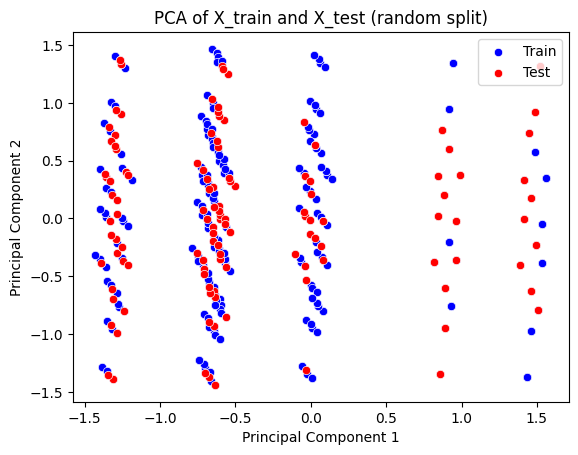

In [6]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = OneHotEncoder(encode_components=['sugar'])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.reshape(len(X_train), -1))
X_test_pca = pca.transform(X_test.reshape(len(X_test), -1))

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (random split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

Due to the nature of the dataset, a clustering analysis is not relevant.


## Labels statistics

In [7]:
dataset.get_label_stats()

,nobs,minmax,mean,variance,skewness,kurtosis,num_zeros
0,768,"(0.0, 1.0)",0.317692,0.043718,0.518754,-0.500647,1


In [8]:
print(f"{len(get_outliers(dataset.y))} datapoints are identified as outliers by IQR method")

0 datapoints are identified as outliers by IQR method


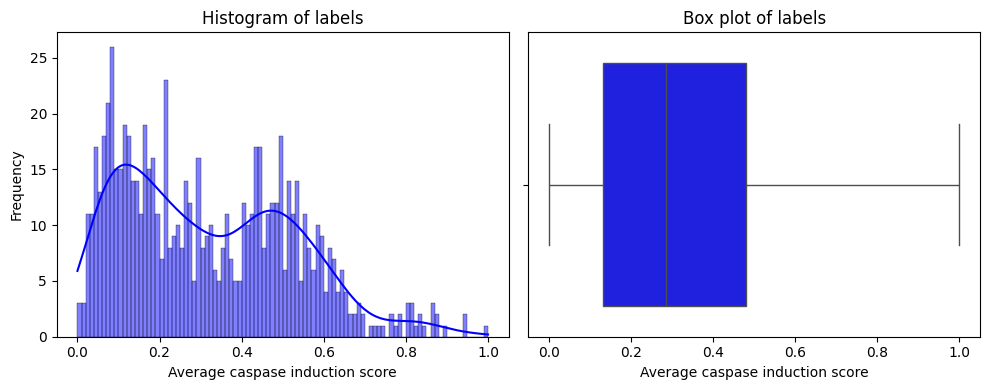

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(dataset.y, ax=axs[0], color='blue', kde=True, bins=100)
axs[0].set_title('Histogram of labels')
axs[0].set_xlabel('Average caspase induction score')
axs[0].set_ylabel('Frequency')

sns.boxplot(x=dataset.y, ax=axs[1], color='blue')
axs[1].set_title('Box plot of labels')
axs[1].set_xlabel('Average caspase induction score')

plt.tight_layout()
plt.show()

In [10]:
print(f"Max raw caspase score: {dataset.data.y_raw.max()}")
print(f"Min raw caspase score: {dataset.data.y_raw.min()}")

Max raw caspase score: 721.1451168211564
Min raw caspase score: 82.88678503607098


# Predictability analysis

In [11]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
featurizer = OneHotEncoder()
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

model = RandomForestModel(task="regression")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
metrics_train = regression_metrics(y_train, y_pred_train)
metrics = regression_metrics(y_test, y_pred)
print(metrics_train)
print(metrics)


{'r2_score': 0.9741553552495392, 'root_mean_squared_error': 0.03338632858268826, 'mean_absolute_error': 0.02316860902823625, 'pearson_correlation': 0.9879547663069161, 'spearman_correlation': 0.9895122638118955}
{'r2_score': 0.8047430692356106, 'root_mean_squared_error': 0.09441042476473922, 'mean_absolute_error': 0.06764846446999771, 'pearson_correlation': 0.8994698132285939, 'spearman_correlation': 0.9002669689576711}


## Recommendation for dataset

The original study (https://doi.org/10.1016/j.omtn.2019.12.011) wanted to investigate the effect of varying position of LNA modification to the toxicity and potency of ASO gapmer. Therefore the nucleobase sequences were kept mostly the same, focusing on particular regions in the HIF1A gene. Therefore a backbone or random based splitting strategy is recommended. However a model trained on this dataset would most likely generalize quite poorly to new sequences. **Its use as part of a predictor for designing new gapmer where the LNA designs are kept mostly the same is therefore not recommended.** 

The caspase induction score seems well distributed with no obvious outliers. Although, the raw score have an unsual scale with minimum around 80 and maximum around 700, therefore a minmax-scaled score is recommended as task label, especially for better convergence of neural network model.